In [ ]:
import sys

In [ ]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

In [ ]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type
from copy import deepcopy

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    compute_distance_using_fmm,
    find_dist_from_map,
    compute_distance_mat_using_navmesh,
    compute_distance_mat_using_fmm,
    find_shortest_path_for_multiple_objects
)
from rearrangement.utils.visualization import (
    get_top_down_map, get_top_down_map_sim
)
from rearrangement.utils.geometry import (
     geodesic_distance
)
from collections import defaultdict

In [ ]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [ ]:
config = habitat.get_config("configs/tasks/rearrangement_debug.yaml")

In [7]:
config.defrost()
config.TASK.SENSORS =  ["GRIPPED_OBJECT_SENSOR", "ALL_OBJECT_POSITIONS", "ALL_OBJECT_GOALS"]
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.DATASET.SPLIT = "test"
config.DATASET.CONTENT_SCENES = ['rearrangement_hard_v8_test_n=100_o=5_t=0.9_Sagerton']
config.freeze()

In [8]:
config.TASK.TOP_DOWN_MAP.MAP_RESOLUTION

256

In [ ]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None
pickup_order = {}
pickup_order_l2dist = {}

2020-11-13 19:26:02,284 Initializing dataset RearrangementDataset-v0
2020-11-13 19:26:02,306 initializing sim RearrangementSim-v0


In [ ]:
len(env.episodes)

In [11]:
def compute_oracle_pickup_order(env):
    # obs = env.reset()
    metrics = env.get_metrics()
    episode = env.current_episode
    metrics = env.get_metrics()

    agent_pos = env._sim.get_agent(0).get_state().position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]
    
    dist_mat = compute_distance_mat_using_navmesh(env._task._simple_pathfinder, agent_pos, object_positions, goal_positions)
    route_indexes_navmesh, pickup_order_navmesh = find_shortest_path_for_multiple_objects(dist_mat)
    
#     top_down_map, fog_of_war_mask = get_top_down_map(
#         env, env._task._simple_pathfinder, ignore_objects=True, fog_of_war_mask=None, draw_fow=False, 
#         draw_agent=False, draw_object_start_pos=False, draw_object_final_pos=False, draw_object_curr_pos=False
#     )
    
    
#     a_y, a_x = maps.to_grid(
#         agent_pos[2],
#         agent_pos[0],
#         top_down_map.shape[0:2],
#         sim=env._sim,
#     )
#     grid_object_positions = []
#     grid_goal_positions = []

#     for i, obj_pos in enumerate(object_positions):
#         tdm_pos = maps.to_grid(
#             obj_pos[2],
#             obj_pos[0],
#             top_down_map.shape[0:2],
#             sim=env._sim,
#         )
#         grid_object_positions.append(tdm_pos)

#     for i, goal_pos in enumerate(goal_positions):
#         tdm_pos = maps.to_grid(
#             goal_pos[2],
#             goal_pos[0],
#             top_down_map.shape[0:2],
#             sim=env._sim,
#         )

#         grid_goal_positions.append(tdm_pos)

#     tdmap = np.copy(top_down_map[:, :, 0])
#     tdmap = tdmap / np.max(tdmap)
#     dist_mat_map = compute_distance_mat_using_fmm(tdmap, [a_y, a_x], grid_object_positions, grid_goal_positions)
    
    
#     route_indexes_map, pickup_order_map = find_shortest_path_for_multiple_objects(dist_mat_map/3)
    
    return {
        'episode_id': episode.episode_id, 
        'scene_id': episode.scene_id,
        'pickup_order': pickup_order_navmesh,
        'dist_mat': dist_mat
        # 'pickup_order_fmm': pickup_order_map 
    }

In [12]:
def compute_l2dist_pickup_order(env):
    # obs = env.reset()
    metrics = env.get_metrics()
    episode = env.current_episode
    metrics = env.get_metrics()

    agent_pos = env._sim.get_agent(0).get_state().position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]
    
    dist_mat = np.zeros((   
            1 + len(object_positions) + len(goal_positions), 
            1 + len(object_positions) + len(goal_positions)
    ))
    
    for i, object_pos in enumerate([agent_pos] + object_positions + goal_positions):
        for j, goal_pos in enumerate([agent_pos] + object_positions + goal_positions):
            if j == 0:  # distance from object / goal position -> "depot" is zero
                dist = 0
            else:
                dist = np.linalg.norm(
                    np.array(object_pos) - np.array(goal_pos), ord=2
                )
            dist_mat[i][j] = dist
    
    route_indexes_map, pickup_order_map = find_shortest_path_for_multiple_objects(dist_mat)
    
    return {
        'episode_id': episode.episode_id, 
        'scene_id': episode.scene_id,
#         'pickup_order': pickup_order_navmesh,
        'pickup_order_l2dist': pickup_order_map 
    }

In [13]:
def start_env_episode_distance(env, task, episode, pickup_order):
    pathfinder = env._task._simple_pathfinder
    agent_pos = episode.start_position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]

    prev_obj_end_pos = agent_pos
    shortest_dist = 0

    for i in range(len(pickup_order)):
        curr_idx = pickup_order[i] - 1
        curr_obj_start_pos = object_positions[curr_idx]
        curr_obj_end_pos = goal_positions[curr_idx]
        shortest_dist += geodesic_distance(
                pathfinder, prev_obj_end_pos, [curr_obj_start_pos]
            )

        shortest_dist += geodesic_distance(
                    pathfinder, curr_obj_start_pos, [curr_obj_end_pos]
                )
        prev_obj_end_pos = curr_obj_end_pos

    return shortest_dist

In [ ]:
# When pickup order is not known! 

l2dists = []
odists = []
l2pos = []
opos = []
ids = []
pod = {}
l2pod = {}

count = 0 
overall_count = 0
for episode in env.episodes: 
    obs = env.reset()
    odata = compute_oracle_pickup_order(env)
    l2data = compute_l2dist_pickup_order(env)
    
    pod[odata['episode_id'] + '_' + odata['scene_id']] = odata
    l2pod[l2data['episode_id'] + '_' + l2data['scene_id']] = l2data
    
    opo = odata['pickup_order']
    l2po = l2data['pickup_order_l2dist']
    opos.append(opo)
    l2pos.append(l2po)
    
    odist = start_env_episode_distance(env, env._task, env.current_episode, opo)
    l2dist = start_env_episode_distance(env, env._task, env.current_episode, l2po)
    
    # print(odist, l2dist)
    if odist == float("inf"):
        break
        
    odists.append(odist)
    l2dists.append(l2dist)
    
    ids.append(env.current_episode.scene_id + '_' + str(env.current_episode.episode_id))
    
    if(overall_count % 10 == 0):
        print(count, overall_count, sum(odists) / sum(l2dists))
    
    if l2dist > odist:
        count += 1
        # print(count, overall_count, float(count/overall_count))
        
    overall_count +=1

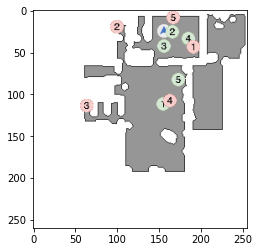

In [36]:
episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]
agent_pos = env._sim.get_agent(0).get_state().position

top_down_map, fow_mask = get_top_down_map_sim(
            env._sim, 
            env._sim.pathfinder, 
            object_positions, 
            goal_positions,
            env._sim.navmesh_settings,
            fog_of_war_mask=None, 
            ignore_objects=True, 
            draw_fow=True, 
            draw_agent=True, 
            draw_object_start_pos=True,
            draw_object_final_pos=True
        )

plt.imshow(top_down_map)

In [37]:
odata = compute_oracle_pickup_order(env)
l2data = compute_l2dist_pickup_order(env)

In [14]:
while(len(pickup_order)!=len(env.episodes)):
    obs = env.reset()
    data = compute_oracle_pickup_order(env)
    pickup_order[data['episode_id'] + '_' + data['scene_id']] = data
    print('\rEpisode ID: {} Done: {} '.format(data['episode_id'], len(pickup_order)), end=" ")

Episode ID: 43 Done: 99  

I1108 20:53:53.030201 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Silerton.navmesh
I1108 20:53:53.032213 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 65 Done: 199  

I1108 20:55:20.839205 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Wells.navmesh
I1108 20:55:20.841036 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 55 Done: 299  

I1108 20:56:36.477941 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Howie.navmesh
I1108 20:56:36.480819 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 78 Done: 399  

I1108 20:58:06.571800 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Southfield.navmesh
I1108 20:58:06.575056 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 45 Done: 499  

I1108 21:00:02.753423 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sagerton.navmesh
I1108 21:00:02.756050 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 9 Done: 599   

I1108 21:01:31.988306 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Starks.navmesh
I1108 21:01:31.991506 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 22 Done: 699  

I1108 21:02:47.245228 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Spencerville.navmesh


Episode ID: 89 Done: 700  

I1108 21:02:47.247480 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 74 Done: 800  

I1108 21:03:57.505261 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Cokeville.navmesh
I1108 21:03:57.507248 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 82 Done: 900  

I1108 21:05:04.727948 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Stockertown.navmesh
I1108 21:05:04.730134 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 19 Done: 1000  

In [15]:
import json_tricks

In [16]:
with open('data/pickup_order_oracle_test_v7.json','w') as f:
    json_tricks.dump(pickup_order, f)

In [17]:
while(len(pickup_order_l2dist)!=len(env.episodes)):
    obs = env.reset()
    data = compute_l2dist_pickup_order(env)
    pickup_order_l2dist[data['episode_id'] + '_' + data['scene_id']] = data
    print('\rEpisode ID: {} Done: {} '.format(data['episode_id'], len(pickup_order_l2dist)), end=" ")

I1108 21:07:43.079074 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Silerton.navmesh
I1108 21:07:43.082715 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 10 Done: 99  

I1108 21:09:10.938479 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sagerton.navmesh
I1108 21:09:10.941794 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 21 Done: 200  

I1108 21:10:37.561433 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Cokeville.navmesh
I1108 21:10:37.562759 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 15 Done: 300  

I1108 21:11:44.281889 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sands.navmesh
I1108 21:11:44.284171 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 92 Done: 400  

I1108 21:13:00.362641 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Wells.navmesh
I1108 21:13:00.364514 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 64 Done: 499  

I1108 21:14:14.276111 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Stockertown.navmesh
I1108 21:14:14.277916 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 97 Done: 599  

I1108 21:16:03.995226 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Howie.navmesh
I1108 21:16:03.998366 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 49 Done: 699  

I1108 21:17:31.438864 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Spencerville.navmesh
I1108 21:17:31.440919 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 51 Done: 800  

I1108 21:18:41.431741 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Starks.navmesh
I1108 21:18:41.434125 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 95 Done: 899  

I1108 21:19:56.835105 39845 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Southfield.navmesh
I1108 21:19:56.836737 39845 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 45 Done: 1000  

In [18]:
with open('data/pickup_order_l2dist_test_v7.json','w') as f:
    json_tricks.dump(pickup_order_l2dist, f)

In [19]:
with open('data/pickup_order_l2dist_test_v7.json','r') as f:
    pickup_order_l2dist = json.load(f)
    
with open('data/pickup_order_oracle_test_v7.json','r') as f:
    pickup_order = json.load(f)

In [20]:
updated_scene_data = []
split = 'test'

for filename in os.listdir('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split)):
    scene_id = filename.split('.')[0].split('_')[-1]
    with gzip.open('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split) + filename, "rt") as f:
        scene_data = json.load(f)
    updated_scene_data = deepcopy(scene_data)
    
    for i, episode in enumerate(scene_data['episodes']):
        episode_id = episode['episode_id']
        assert updated_scene_data['episodes'][i]['episode_id'] == episode['episode_id']
        assert updated_scene_data['episodes'][i]['scene_id'] == episode['scene_id']
        updated_scene_data['episodes'][i]['pickup_order'] = pickup_order[str(episode['episode_id']) + "_" + episode['scene_id']]['pickup_order']
        updated_scene_data['episodes'][i]['pickup_order_l2dist'] = pickup_order_l2dist[str(episode['episode_id']) + "_" + episode['scene_id']]['pickup_order_l2dist']
    
    
    with gzip.open('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split) + filename, "wt") as f:
        json.dump(updated_scene_data, f)
        
    print(filename)

rearrangement_hard_v7_test_n=100_o=5_t=0.9_Southfield.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Wells.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Spencerville.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Silerton.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Starks.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Cokeville.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Sagerton.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Sands.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Stockertown.json.gz
rearrangement_hard_v7_test_n=100_o=5_t=0.9_Howie.json.gz


In [21]:
updated_scene_data['episodes'][0]

{'episode_id': 0,
 'scene_id': 'data/scene_datasets/gibson_train_val/Howie.glb',
 'start_position': [0.5537213087081909,
  0.16467072069644928,
  -4.965640544891357],
 'start_rotation': [0.0, 0.0, 0.0, 1.0],
 'info': {},
 'objects': [{'object_id': 0,
   'object_handle': 'data/ycb/065-b_cups.phys_properties.json',
   'position': [-8.058152198791504, 0.19665321707725525, -7.6187944412231445],
   'rotation': [-0.4999999701976776,
    0.4999999701976776,
    0.4999999701976776,
    0.4999999701976776]},
  {'object_id': 1,
   'object_handle': 'data/ycb/065-e_cups.phys_properties.json',
   'position': [-7.388972282409668, 0.200059711933136, -1.1077078580856323],
   'rotation': [-0.4999999701976776,
    0.4999999701976776,
    0.4999999701976776,
    0.4999999701976776]},
  {'object_id': 2,
   'object_handle': 'data/ycb/004_sugar_box.phys_properties.json',
   'position': [0.05163535475730896, 0.2526782155036926, -7.4625067710876465],
   'rotation': [-0.4999999701976776,
    0.4999999701976776